# Random search - 50 split

For each patient, we used half channels for learning and the remaining half for test. The proportion between critical and non critical channels in each set are kept fixed. The learning set is used for model selection to identify the optimal hyperparameters with a 3-fold cross validation procedure. To speed up the computation, we resort to a random search in the range of the hyperparameters, selecting 120 different tuples for each fold. We use then the hyperparameters to train over all the learning set and to assess the performances over the test set. This procedure is repeated 50 times through shuffle split procedure, to assess the stability of the results. 

In [8]:
import os
from os.path import join
import pickle
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt

%matplotlib inline

**Function for plots**

In [9]:
def ax_default(fignum, ax):
    if ax is None:
        fig = plt.figure(fignum)
        ax = fig.add_subplot(111)
    else:
        fig = ax.figure
    return fig, ax

In [10]:
def ax_set_defaults(ax):
    ax.grid(True)
    ax.set_frame_on(False)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xmargin(0)
    ax.set_ymargin(0)
    ax.grid(axis='both', alpha=.5, ls=':', lw=1.5, zorder=30, color='.5')
    return ax

In [11]:
def meanplot(x, mu, color="C0", ax=None, fignum=None,
            linewidth=2, **kw):
    _, axes = ax_default(fignum, ax)
    # return axes.plot(x, mu, color=color, linewidth=linewidth, **kw)
    return axes.plot(x, mu, color=color, linewidth=None,  **kw)

In [12]:
def dmiplot(x, mu, lower, upper=None, edgecol="C0",
           fillcol="lightblue", marker=None, linestyle='-',
           mlabel=None, ax=None, fignum=None, **kwargs):
    _, axes = ax_default(fignum, ax)

    mu = mu.flatten()
    x = x.flatten()
    lower = lower.flatten()
    upper = upper.flatten()

    plots = []

    # here's the mean
    plots.append(meanplot(x, mu, edgecol, axes, marker=marker,
                          linestyle=linestyle, label=mlabel))

    # here's the box
    kwargs['linewidth'] = 0.5
    if 'alpha' not in kwargs.keys():
        kwargs['alpha'] = 0.3
    plots.append(axes.fill(np.hstack((x, x[::-1])),
                 np.hstack((upper, lower[::-1])), color=fillcol, **kwargs))

    plots.append(meanplot(x, upper, color=edgecol, linewidth=0.2, ax=axes))
    plots.append(meanplot(x, lower, color=edgecol, linewidth=0.2, ax=axes))

    return plots

**Balanced accuracy**

To load the file with results we need the balanced accuracy definition

In [13]:
import palladio.metrics

def balanced_accuracy_multiple(y_true, y_pred, sample_weight=None):
    ba = [palladio.metrics.balanced_accuracy_score(yt, yp) for yt, yp in zip(y_true, y_pred)]
    return np.mean(ba)

### Load the files

Here we load the different files - the ones for kernels, the labels, the results from the learning procedure, the list of frequency corresponding to 100 kernels

The most important file is the pkl, which contains the results over the test set and the best models, across the 50 repetitions of the experiments. The results are saved as dictionaries - the **estimator** key is the one that returns the models/ best parameters and so on

In [ ]:
# here we removed the part where we load the patients file - patients ID

In [15]:
freqs = np.load("freqs.npy")
kernellist = pd.read_pickle("kernelZ.pkl")

In [16]:
pp = pickle.load(open("random_search_50split.pkl", "rb"))

In [17]:
estimators = pp["estimator"]
train_index = pp["train_index"]
test_index = pp["test_index"]
data = X_list
labels = y_list

In [18]:
len(estimators)

50

### Plots of the best coefficients - kernels weights

Here we want to plot the best results obtained from the learning set. In particular we are interested to see what are the most relevant kernels across the 50 repetitions.

In [19]:
mean_w = np.mean([x.best_estimator_.coef_.ravel() for x in estimators], axis=0)
std_w = np.std([x.best_estimator_.coef_.ravel() for x in  estimators], axis=0)
occurence_w = np.mean([x.best_estimator_.coef_.ravel()>0 for x in estimators], axis=0)

idx = np.lexsort([mean_w, occurence_w])[::-1]
idx_nonzero = np.where(occurence_w[idx] != 0)[0]

mean = mean_w[idx][idx_nonzero]
std = std_w[idx][idx_nonzero]
occurence = occurence_w[idx][idx_nonzero]
kernels = kernellist[idx][idx_nonzero]

x = np.arange(mean.size)

In [20]:
xlabel = []
for k in kernels:
    tmp_line = k.split("_")
    name = "PLV" if (tmp_line)[0] == "plv" else ("CC" if (tmp_line)[0]=="corrcoef" else "CH")
    xlabel.append("{} {} Hz".format(name, round(freqs[int(tmp_line[-1])-1], 1)))

In [26]:
tmp_freq = [int("".join(g.split(" ")[1:2])[:-2]) for g in xlabel]
event_type = []
for f in tmp_freq:
    if f >=100:
        tmp="high freqs"
    elif (f<100 and f>70):
        tmp=r"high-$\gamma$"
    elif (f<70 and f>30):
        tmp=r"$\gamma$"
    elif (f<30 and f>13):
        tmp=r"$\beta$"
    elif (f<13 and f>8):
        tmp=r"$\alpha$"
    elif (f<8 and f>4):
        tmp =r"$\theta$"   
    elif (f>1 and f<4):
        tmp=r"$\delta$" 
    else:
        tmp="low freqs"
    event_type.append(tmp)

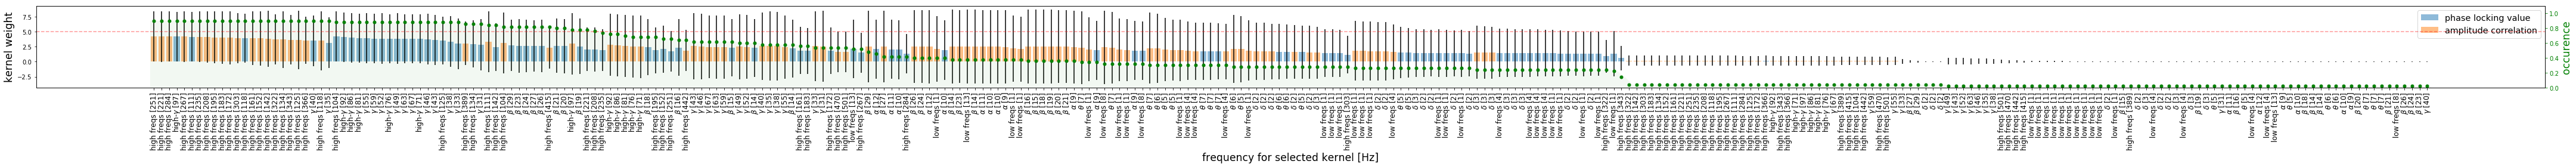

In [37]:
figure, ax = plt.subplots(figsize=(60, 4))

# dmiplot(x, mean, mean-std, mean+std, ax=ax, marker='s')
#plt.errorbar(x, mean, std, marker="s" , ms=5, ls='')
#ax.fill_between(x, 0, mean, alpha=0.1)

ax2 = ax.twinx()
ax2.plot(x, occurence, 'o', c="green", ms=5)
ax2.fill_between(np.insert(x + 0.5, 0, -0.5), 0, np.insert(occurence, 0, occurence[0]), 
                 #where=np.insert(occurence, 0, 1) >= 0.75,
                 facecolor='green', alpha=0.05)
#ax2.fill_between(np.insert(x + 0.5, 0, -0.5), 0.75, 1.1, facecolor='C1', alpha=0.1)
ax2.axhline(0.75, linestyle='--', color='red', alpha=0.4)
#ax2.axvline(0.5+np.where((occurence) >= 0.75)[0][-1], linestyle='--', color='C1', alpha=0.4)
ax2.set_ylabel("occurence", color='green', fontsize='xx-large')
ax2.tick_params('y', colors='green')
ax2.set_ylim([0, 1.1])
# ax2.plot(x, 0.75*np.ones(mean_w.size))

ax.set_xticks(x)
ax.set_ylabel("kernel weight", fontsize='xx-large')
ax.tick_params('y')
ax.set_xticklabels([e+" ["+"".join(g.split(" ")[1:2])[:-2]+"]" 
                    for e,g in zip(event_type, xlabel)], rotation=90, fontsize='large');
# ax.set_ylim([0, np.max(mean_w)+1])
# ax.fill_between(x, 0, mean, where= [l.startswith("PLV") for l in xlabel], 
#                 facecolor='green', alpha=0.5, interpolate=True)
# ax.fill_between(x, 0, mean, where= [l.startswith("CC") for l in xlabel], 
#                 facecolor='cc', alpha=0.5, interpolate=True)

idx_plv = np.array([l.startswith("PLV") for l in xlabel])
ax.bar(x[idx_plv], mean[idx_plv], yerr=std[idx_plv], alpha=0.5, label="phase locking value")
ax.bar(x[~idx_plv], mean[~idx_plv], yerr=std[~idx_plv], alpha=0.5, label="amplitude correlation")
ax.set_xlabel("frequency for selected kernel [Hz]", fontsize='xx-large')
# alpha=0.8 if occurence[idx_plv] >=0.75 else 0.1
ax.legend(fontsize='x-large')
figure.tight_layout()
plt.savefig("random_search_50splits.pdf",
             transparent=True, bbox_inches='tight')

differently from what happened when we use the train and validation set only, the results are pretty unstable. Indeed the black lines corresponds to the standard deviations across the 50 repetitions. The cross correlation is again never selected in this case. 

We check then what happens most of the times (above 70% of the repetitions)

### Selected frequency bands with occurence value higher than 70%

In [32]:
idx70 = occurence > 0.7

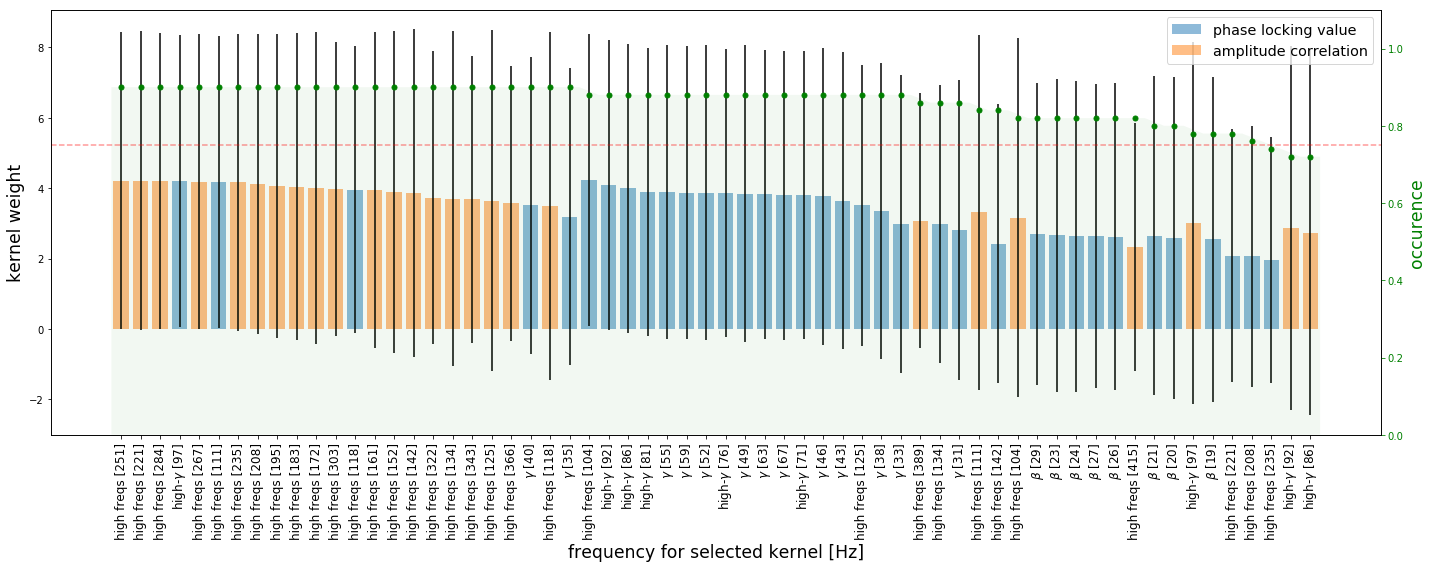

In [41]:
figure, ax = plt.subplots(figsize=(20,8))

# dmiplot(x, mean, mean-std, mean+std, ax=ax, marker='s')
#plt.errorbar(x, mean, std, marker="s" , ms=5, ls='')
#ax.fill_between(x, 0, mean, alpha=0.1)

ax2 = ax.twinx()
ax2.plot(x[idx70], occurence[idx70], 'o', c="green", ms=5)
ax2.fill_between(np.insert(x[idx70] + 0.5, 0, -0.5), 0, np.insert(occurence[idx70], 0, occurence[0]), 
                 #where=np.insert(occurence, 0, 1) >= 0.75,
                 facecolor='green', alpha=0.05)
#ax2.fill_between(np.insert(x + 0.5, 0, -0.5), 0.75, 1.1, facecolor='C1', alpha=0.1)
ax2.axhline(0.75, linestyle='--', color='red', alpha=0.4)
#ax2.axvline(0.5+np.where((occurence) >= 0.75)[0][-1], linestyle='--', color='C1', alpha=0.4)
ax2.set_ylabel("occurence", color='green', fontsize='xx-large')
ax2.tick_params('y', colors='green')
ax2.set_ylim([0, 1.1])
# ax2.plot(x, 0.75*np.ones(mean_w.size))

ax.set_xticks(x[idx70])
ax.set_ylabel("kernel weight", fontsize='xx-large')
ax.tick_params('y')
ax.set_xticklabels([e+" ["+"".join(g.split(" ")[1:2])[:-2]+"]" 
                    for e,g in zip(event_type, xlabel)], rotation=90, fontsize='large');
# ax.set_ylim([0, np.max(mean_w)+1])
# ax.fill_between(x, 0, mean, where= [l.startswith("PLV") for l in xlabel], 
#                 facecolor='green', alpha=0.5, interpolate=True)
# ax.fill_between(x, 0, mean, where= [l.startswith("CC") for l in xlabel], 
#                 facecolor='cc', alpha=0.5, interpolate=True)

idx_plv = np.array([l.startswith("PLV") for l in xlabel])
ax.bar(x[np.logical_and(idx_plv, idx70)], 
       mean[np.logical_and(idx_plv, idx70)], 
       yerr=std[np.logical_and(idx_plv, idx70)], 
       alpha=0.5, label="phase locking value")
ax.bar(x[np.logical_and(~idx_plv, idx70)],
       mean[np.logical_and(~idx_plv, idx70)], 
       yerr=std[np.logical_and(~idx_plv, idx70)], 
       alpha=0.5, label="amplitude correlation")
ax.set_xlabel("frequency for selected kernel [Hz]", fontsize='xx-large')
# alpha=0.8 if occurence[idx_plv] >=0.75 else 0.1
ax.legend(fontsize='x-large')
figure.tight_layout()
plt.savefig("random_search_50splits_70.pdf",
             transparent=True, bbox_inches='tight')

The plot here show a high contribute of high frequency bands, as for the first versions of the experiments, where we rely on the performances over the validation set only

### Median - confidence interval

We try to see if by looking at median and confidence interval the results become more stable

In [110]:
import numpy as np, scipy.stats as st

def confidence(x):
    return st.t.interval(0.5, len(x)-1, loc=np.mean(x), scale=st.sem(x))

In [111]:
ww = np.array([x.best_estimator_.coef_.ravel() for x in estimators])

print(ww.shape)

(50, 300)


In [112]:
median_w = np.median([x.best_estimator_.coef_.ravel() for x in estimators], axis=0)
mean_w = np.mean([x.best_estimator_.coef_.ravel() for x in estimators], axis=0)
conf_w = np.array([confidence(weight) for weight in ww.T]).T
occurence_w = np.mean([x.best_estimator_.coef_.ravel()>0 for x in estimators], axis=0)

In [113]:
lb = conf_w[0]
ub = conf_w[1]

In [114]:
idx = np.lexsort([median_w, occurence_w])[::-1]
idx_nonzero = np.where(occurence_w[idx] != 0)[0]

median = median_w[idx][idx_nonzero]
mean = mean[idx][idx_nonzero]
lb_sp = lb[idx][idx_nonzero]
ub_sp = ub[idx][idx_nonzero]
occurence = occurence_w[idx][idx_nonzero]
kernels = kernellist[idx][idx_nonzero]

x = np.arange(mean.size)

In [115]:
xlabel = []
for k in kernels:
    tmp_line = k.split("_")
    name = "PLV" if (tmp_line)[0] == "plv" else ("CC" if (tmp_line)[0]=="corrcoef" else "CH")
    xlabel.append("{} {} Hz".format(name, round(freqs[int(tmp_line[-1])-1], 1)))

In [116]:
tmp_freq = [int("".join(g.split(" ")[1:2])[:-2]) for g in xlabel]
event_type = []
for f in tmp_freq:
    if f >=100:
        tmp="HFO "
    elif (f<100 and f>70):
        tmp=r"high-$\gamma$"
    elif (f<70 and f>30):
        tmp=r"$\gamma$"
    elif (f<30 and f>13):
        tmp=r"$\beta$"
    elif (f<13 and f>8):
        tmp=r"$\alpha$"
    else:
        tmp="low freqs"
    event_type.append(tmp)

In [174]:
def plot_mean_and_CI(x, lb, ub, event_type, xlabel, color_mean='r', color_shading='r'):
    
    figure, ax = plt.subplots(figsize=(60, 4))
    # plot the shaded range of the confidence intervals
    plt.fill_between(range(x.shape[0]), ub, lb,
                     color=color_shading, alpha=.3)
    # plot the mean on top
    tks = np.arange(x.size) 
    ax.set_xticks(tks)
    
    ax2 = ax.twinx()
    ax2.plot(tks, occurence, 'o', c="green", ms=5)
    ax2.axhline(1., linestyle='--', color='green', alpha=0.4)
    ax2.axhline(.5, linestyle='--', color='green', alpha=0.4)

    ax.set_xticklabels([e+" ["+"".join(g.split(" ")[1:2])[:-2]+"]" 
                    for e,g in zip(event_type, xlabel)], rotation=90, fontsize='large');

    # ax.plot(tks, x, color_mean)
    ax.axhline(0., linestyle="--", color='r', alpha=1.)
    
    idx_plv = np.array([l.startswith("PLV") for l in xlabel])
    ax.plot(tks[idx_plv], x[idx_plv], 'o', label="phase locking value")
    ax.plot(tks[~idx_plv], x[~idx_plv], '*', label="amplitude correlation")
    ax.set_xlabel("frequency for selected kernel [Hz]", fontsize='xx-large')
    # alpha=0.8 if occurence[idx_plv] >=0.75 else 0.1
    ax.legend(fontsize='x-large')
    
    
    plt.savefig("centered_median_confidence_5.pdf")

In [24]:
idx = np.lexsort([mean_w, occurence_w])[::-1]
idx_nonzero = np.where(occurence_w[idx] != 0)[0]

mean = mean_w[idx][idx_nonzero]
std = std_w[idx][idx_nonzero]
occurence = occurence_w[idx][idx_nonzero]
kernels = kernellist[idx][idx_nonzero]

x = np.arange(mean.size)

(2, 300)


50
((300,), (300,), (300,), 300, 300)


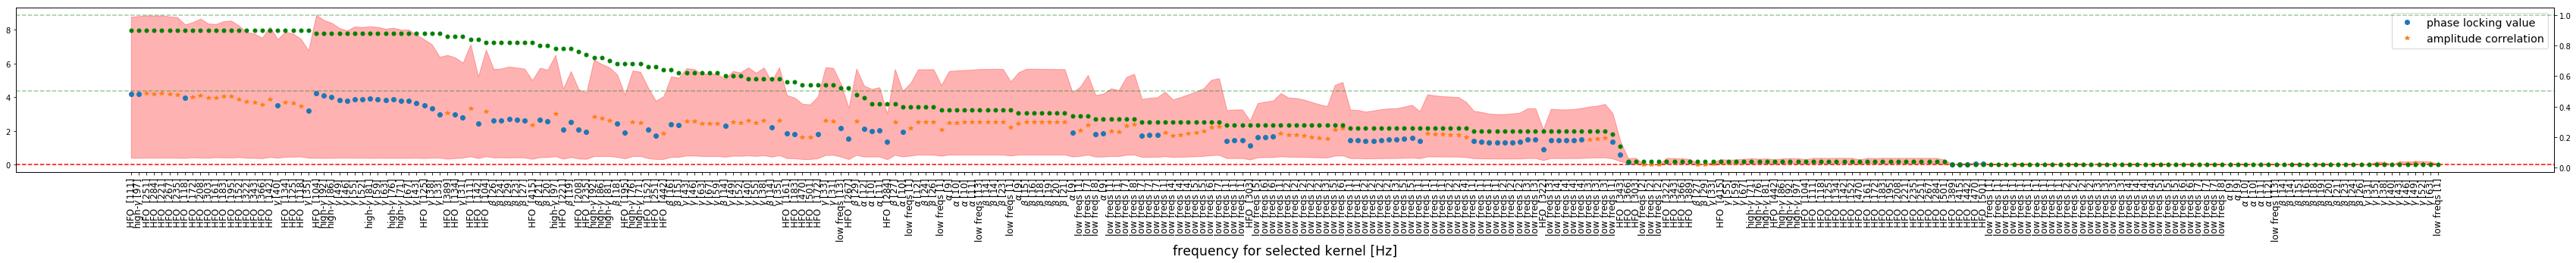

In [178]:
idx_sparse = np.array(hyperparams[hyperparams["l1beta"] > 0.].index)

sparse_estimators = [estimators[ii] for ii in idx_sparse]
ww = np.array([x.best_estimator_.coef_.ravel() for x in sparse_estimators])

print(len(sparse_estimators))

median_w = np.median([x.best_estimator_.coef_.ravel() for x in sparse_estimators], axis=0)
mean_w = np.mean([x.best_estimator_.coef_.ravel() for x in sparse_estimators], axis=0)
conf_w = np.array([confidence(weight) for weight in ww.T]).T
occurence_w = np.mean([x.best_estimator_.coef_.ravel()>0 for x in sparse_estimators], axis=0)

lb = conf_w[0]
ub = conf_w[1]

idx = np.lexsort([median_w, occurence_w])[::-1]
idx_nonzero = np.where(occurence_w[idx] != 0)[0]

median = median_w[idx][idx_nonzero]
mean = mean_w[idx][idx_nonzero]
lb_sp = lb[idx][idx_nonzero]
ub_sp = ub[idx][idx_nonzero]
occurence = occurence_w[idx][idx_nonzero]
kernels = kernellist[idx][idx_nonzero]

xlabel = []
for k in kernels:
    tmp_line = k.split("_")
    name = "PLV" if (tmp_line)[0] == "plv" else ("CC" if (tmp_line)[0]=="corrcoef" else "CH")
    xlabel.append("{} {} Hz".format(name, round(freqs[int(tmp_line[-1])-1], 1)))

tmp_freq = [int("".join(g.split(" ")[1:2])[:-2]) for g in xlabel]
event_type = []
for f in tmp_freq:
    if f >=100:
        tmp="HFO "
    elif (f<100 and f>70):
        tmp=r"high-$\gamma$"
    elif (f<70 and f>30):
        tmp=r"$\gamma$"
    elif (f<30 and f>13):
        tmp=r"$\beta$"
    elif (f<13 and f>8):
        tmp=r"$\alpha$"
    else:
        tmp=r"low freqs"
    event_type.append(tmp)
    
x = np.arange(mean.size)
print(mean.shape, lb_sp.shape, ub_sp.shape, len(event_type), len(xlabel))

plot_mean_and_CI(mean, mean-lb_sp, mean+ub_sp, event_type, xlabel)

### Parameters selection

Here we want to verify if the selection of the hyperparameters is stable across repetitions of the experiments, given the high variability of the frequency bands weight. 

$\lambda$ and $r_\lambda$ are the parameters related to the channels weights

$\beta$ and $r_\beta$ are regularization constants for kernel coefficients

In [43]:
dd = {}
dd["lambda"] = [ee.best_params_["lamda"] for ee in estimators]
dd["l1lambda"] = [ee.best_params_["l1_ratio_lamda"] for ee in estimators]
dd["beta"] = [ee.best_params_["beta"] for ee in estimators]
dd["l1beta"] = [ee.best_params_["l1_ratio_beta"] for ee in estimators]
dd["score"] = [ee.best_score_ for ee in estimators]

hyperparams = pd.DataFrame(dd)
hyperparams

,beta,l1beta,l1lambda,lambda,score
0,0.226832,0.291167,0.396810,0.074891,0.833858
1,0.325273,0.945173,0.845156,0.623831,0.810175
2,0.511777,0.814331,0.823356,0.574937,0.794793
3,0.118216,0.645882,0.472472,0.070771,0.816371
4,0.084437,0.438528,0.321049,0.080111,0.813782
5,0.153806,0.307621,0.588824,0.048362,0.838658
6,0.273481,0.710260,0.566652,0.621434,0.812157
7,0.722417,0.504372,0.736865,0.573416,0.809794
8,0.382894,0.774987,0.492039,0.632541,0.772224
9,0.107021,0.758656,0.533882,0.063244,0.815734


In [44]:
pd.DataFrame([hyperparams.mean(), hyperparams.std()], index=["mean", "std"])

,beta,l1beta,l1lambda,lambda,score
mean,0.297018,0.608369,0.637717,0.331140,0.807726
std,0.219731,0.206808,0.201858,0.294366,0.014718


** score ** the mean balanced accuracy score is very high and stable across the repetitions of the experiments. 

This is extremely interesting, because all the hyperparameters have very high variances. 

It seems that the predictions are pretty independent on the parameters values

This highlights two different aspects

1) the independency of the classification results on the regularization parameters can be a evidence of correlation between training and test data
2) the learning problem can have multiple solution - there is more than one way to classify correctly the channels activity, and this leads to considerations on redundancy